## Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
import matplotlib.pyplot as plt
import os
import random

## GRU RNN - Pranav

## LSTM - Teresa

In [ ]:
movieRev = pd.read_csv("IMDB Dataset.csv")
movieRev

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Equal amounts, so there is no need to normalize
movieRev['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Preprocessing

In [ ]:
# Find the review with the highest number of words
def maxWords(reviewList):
    words = 5000        # Arbitrary value for max words
    for review in reviewList:
        if (len(review.split()) > words):
            words = len(review.split())
            
    return words

In [ ]:
reviewList = movieRev['review'].tolist()
words = maxWords(reviewList)
print(words)

5000


In [ ]:
# Convert categorical values to numeric using factorize()
sentiment_label = movieRev['sentiment'].factorize()
print(sentiment_label[0])

[0 0 0 ... 1 1 1]


In [ ]:
text = movieRev['review'].values

# Tokenize the words in text and fit to associate the words and labels
tokenizer = Tokenizer(num_words=words)
tokenizer.fit_on_texts(text)

# Identify the size of vocabulary
vocab_size = len(tokenizer.word_index) + 1

# Replace words with their assigned numbers using text_to_sequence()
encoding = tokenizer.texts_to_sequences(text)

# Add padding so sentences can have equal length
pad_sequence = pad_sequences(encoding, maxlen=200)

### LSTM Classifier

In [ ]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           3976096   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,058,657
Trainable params: 4,058,657
Non-trainable params: 0
____________________________________________

### Train Model

**[CAUTION]** May take over 30 minutes to run. <br>
Base Model: 5 epochs, batch_size=32, validation_split=0.2

In [ ]:
# Train for 5 epochs with batch size 32 and validation split 20%
history = model.fit(pad_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
1250/1250 [==============================] - 338s 269ms/step - loss: 0.4313 - accuracy: 0.7968 - val_loss: 0.3595 - val_accuracy: 0.8388
Epoch 2/5
1250/1250 [==============================] - 358s 286ms/step - loss: 0.3044 - accuracy: 0.8758 - val_loss: 0.3375 - val_accuracy: 0.8548
Epoch 3/5
1250/1250 [==============================] - 359s 288ms/step - loss: 0.2751 - accuracy: 0.8914 - val_loss: 0.2921 - val_accuracy: 0.8827
Epoch 4/5
1250/1250 [==============================] - 348s 279ms/step - loss: 0.2532 - accuracy: 0.8988 - val_loss: 0.2827 - val_accuracy: 0.8812
Epoch 5/5
1250/1250 [==============================] - 381s 305ms/step - loss: 0.2439 - accuracy: 0.9042 - val_loss: 0.2936 - val_accuracy: 0.8817


### Results

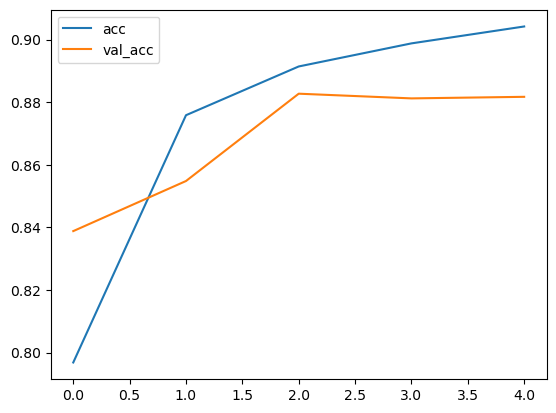

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

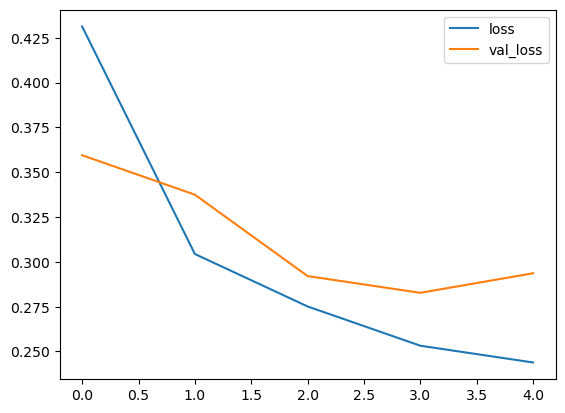

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Predict using Model

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
#     print("Predicted label: ", sentiment_label[1][prediction])
    return sentiment_label[1][prediction]

test_sentence1 = "I enjoyed this movie. The actors were very inspirational."
print(predict_sentiment(test_sentence1))

test_sentence2 = "This is the worst movie I've ever seen in my life!"
print(predict_sentiment(test_sentence2))

1/1 [==============================] - 0s 358ms/step
positive
1/1 [==============================] - 0s 45ms/step
negative


In [ ]:
# Check Positive and Negative Testing Examples
print("Number of Positive Examples:", len(os.listdir("teresa_pham/aclImdb/test/pos/")))
print("Number of Negative Examples:", len(os.listdir("teresa_pham/aclImdb/test/neg/")))

Number of Positive Examples: 12500
Number of Negative Examples: 12500


In [ ]:
# Predict all files' content in the test directory (first 500 examples)
def predict_all(fileList, predict):
    count = 0
    total = 0
    if predict == "positive":
        cur_dir = os.getcwd() + "/teresa_pham//aclImdb/test/pos/"
    else:
        cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/neg/"
        
    for file in fileList:
        f = open(cur_dir+ file, "r")
        val = predict_sentiment(f.read())
        if val==predict:
            count += 1
        total += 1
        
    return float(count/total)
        
pos_examples = os.listdir("teresa_pham/aclImdb/test/pos/")[:1000]
neg_examples = os.listdir("teresa_pham/aclImdb/test/neg/")[:1000]
predict_pos = predict_all(pos_examples, "positive")
predict_neg = predict_all(neg_examples, "negative")

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


In [ ]:
print("Predict Positive Accuracy:", predict_pos)
print("Predict Negative Accuracy:", predict_neg)

Predict Positive Accuracy: 0.948
Predict Negative Accuracy: 0.892


In [ ]:
# Predict all files' content in the test directory (first 500 examples)
def predict_all_mixed(fileList, predictList):
    count = 0
    total = 0

    for file in fileList:
        if predictList[total] == "positive":
            cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/pos/"
        else:
            cur_dir = os.getcwd() + "/teresa_pham/aclImdb/test/neg/"

        f = open(cur_dir+ file, "r")
        val = predict_sentiment(f.read())
        if val==predictList[total]:
            count += 1
        total += 1
        
    return float(count/total)

In [ ]:
mix_examples = os.listdir("teresa_pham/aclImdb/test/pos/")[1000:2000] + os.listdir("teresa_pham/aclImdb/test/neg/")[2000:3000]
pos = ["positive" for i in range(1000)]
neg = ["negative" for j in range(1000)]
mix_list = pos + neg

# Randomize the examples
temp = list(zip(mix_examples, mix_list))
random.shuffle(temp)
mixEx, mixList = zip(*temp)
mixEx, mixList = list(mixEx), list(mixList)

predict_mix = predict_all_mixed(mixEx, mixList)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 51ms/step


In [ ]:
print("Mixed List Accuracy:", predict_mix)

## Transformer-based Model - Tri Quan Do

In [ ]:
!pip install transformers

In [2]:
import torch
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizer

In [ ]:
# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=1
    )
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased'
    )

In [4]:
# Load and preprocess data
with open('original_rt_snippets.txt', 'r') as f:
    data_texts = f.readlines()

with open('sentiment_labels.txt', 'r') as f:
    data_label = f.readlines()

data_texts = data_texts[0:100]
data_label = data_label[1:101]

In [5]:
labels = []
sentences = []

for i in range(len(data_texts)):
  label_id, label_val = data_label[i].split('|')
  labels.append(float(label_val[:-1]))
  sentences.append(data_texts[i][:-1])

In [6]:
# Tokenize input sentences
encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Convert labels to tensor
labels_tensor = torch.FloatTensor(labels).unsqueeze(1)

In [7]:
def remover_str(my_string, value3):
  """
  Removes all characters from a string that are not present 
  in a given list of allowed characters.
  Args:
      my_string (str): The string to be modified.
      value3 (list): A list of allowed characters.
  Returns:
      str: The modified string with all characters not present 
           in the given list removed.
  Raises:
      None
  """
  for item in my_string:
    if item not in value3:
      my_string = my_string.replace(item, "")
  return my_string

In [8]:
# Methodology to assign label when no label given
# The map Reduce will base on the sentiment to assign
# an appropriate score the a sentence
def map_reduce(dataFrame, positive=[], negative=[]):
  """
  Assigns a sentiment score to each sentence in the DataFrame based on positive and negative words.
  Args:
      dataFrame (pandas.DataFrame): A DataFrame containing the text data to be analyzed.
      positive (list, optional): A list of positive words to use for sentiment analysis. 
                                 Defaults to an empty list.
      negative (list, optional): A list of negative words to use for sentiment analysis. 
                                 Defaults to an empty list.
  Returns:
      tuple: A tuple containing the review sentiment scores, 
            description length scores, and the number of sentences analyzed.
  Raises:
      None
  """
  if len(dataFrame) == 0:
    return None
  if len(positive)== 0 or len(negative)==0:
    return None
  
  sentimentString = dataFrame.astype(str)
  tDesc = sentimentString['description']        # has all the original tweets

  value3 = list("abcdefghijklmnopqrstuvwxyz")  # Original list of alphabet

  sentimentString = dataFrame.astype(str)
  desWords = sentimentString['description'].apply(str.lower).str.split()

  n = 0;  #assigns a unique n value to each sentence

  reviewSentiment = {} # used to save n as key and score as value
  descLen = {}         # saves n as key and score/length as value

  for string in desWords:
    length = 0
    reviewSentiment[n] = 0
    for word in string:
      length += 1
      word = remover_str(word, value3)
      if word in positive:
        reviewSentiment[n] += 1
      if word in negative:
        reviewSentiment[n] -= 1

    if reviewSentiment[n] != 0:
      descLen[n] = reviewSentiment[n]/length
    n += 1

  return reviewSentiment, descLen, n

In [11]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
lost_lsts = []
epoch_num = []

for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    outputs = model(**encoded_inputs, labels=labels_tensor)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    print('Epoch:', epoch, 'Training Loss:', loss.item())
    lost_lsts.append(loss.item())
    epoch_num.append(epoch)

Epoch: 0 Training Loss: 0.30182328820228577
Epoch: 1 Training Loss: 0.18927665054798126
Epoch: 2 Training Loss: 0.10524895042181015
Epoch: 3 Training Loss: 0.05411669239401817
Epoch: 4 Training Loss: 0.03309875354170799
Epoch: 5 Training Loss: 0.05393980070948601
Epoch: 6 Training Loss: 0.06654722988605499
Epoch: 7 Training Loss: 0.0536031499505043
Epoch: 8 Training Loss: 0.05408085510134697
Epoch: 9 Training Loss: 0.03758426010608673


In [12]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(**encoded_inputs)
    predictions = outputs.logits.squeeze().tolist()

In [13]:
# Print some example predictions
for i in range(10):
    print("Sentence:", sentences[i])
    print("True score:", labels[i])
    print("Predicted score:", predictions[i])
    print()

Sentence: The Rock is destined to be the 21st Century's new ``Conan'' and that he's going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal.
True score: 0.5
Predicted score: 0.5125424861907959

Sentence: The gorgeously elaborate continuation of ``The Lord of the Rings'' trilogy is so huge that a column of words cannot adequately describe co-writer/director Peter Jackson's expanded vision of J.R.R. Tolkien's Middle-earth.
True score: 0.5
Predicted score: 0.5422767400741577

Sentence: Effective but too-tepid biopic
True score: 0.44444
Predicted score: 0.5646920204162598

Sentence: If you sometimes like to go to the movies to have fun, Wasabi is a good place to start.
True score: 0.5
Predicted score: 0.5085318684577942

Sentence: Emerges as something rare, an issue movie that's so honest and keenly observed that it doesn't feel like one.
True score: 0.42708
Predicted score: 0.5349981188774109

Sentence: The film provides some great insight into

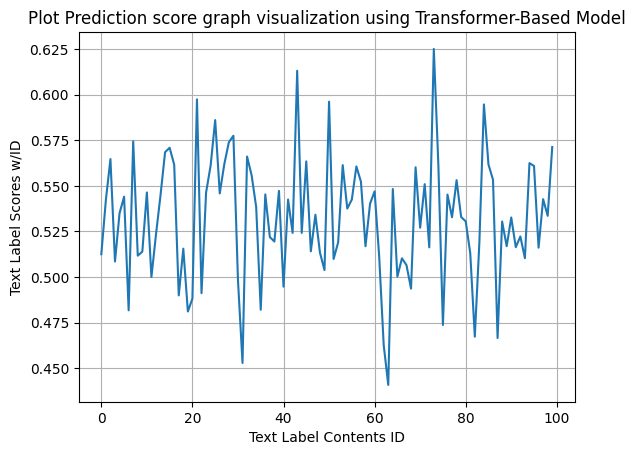

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Prediction score graph visualization
predict_score = predictions
texting_label = range(0, len(predict_score))

plt.figure()
plt.plot(texting_label, predict_score, marker='')
plt.xlabel('Text Label Contents ID')
plt.ylabel('Text Label Scores w/ID')
plt.title('Plot Prediction score graph visualization using Transformer-Based Model')
plt.grid(True)
plt.show()

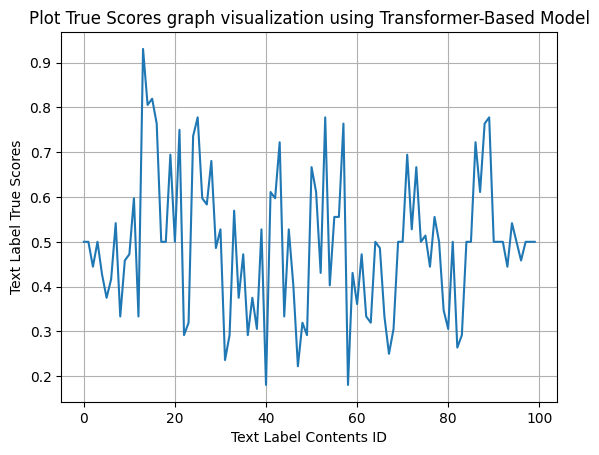

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.figure()
plt.plot(texting_label, labels, marker='')
plt.xlabel('Text Label Contents ID')
plt.ylabel('Text Label True Scores')
plt.title('Plot True Scores graph visualization using Transformer-Based Model')
plt.grid(True)
plt.show()

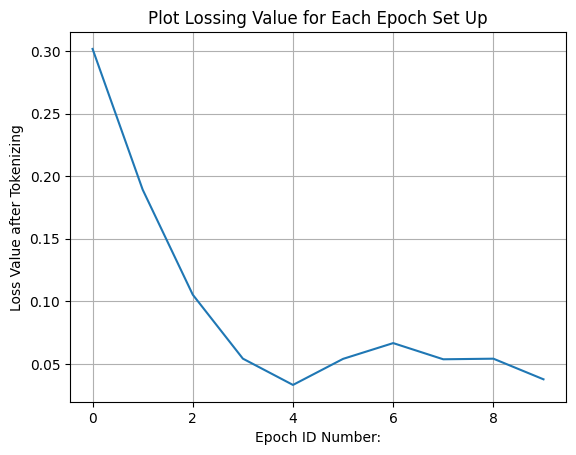

In [18]:
plt.figure()
plt.plot(epoch_num, lost_lsts, marker='')
plt.xlabel('Epoch ID Number:')
plt.ylabel('Loss Value after Tokenizing')
plt.title('Plot Lossing Value for Each Epoch Set Up')
plt.grid(True)
plt.show()

In [16]:
text_string = "Hello, I kinda love this movie and I may join that again in the future"

# Tokenize input string
encoded_input = tokenizer(text_string, padding=True, truncation=True, return_tensors="pt")

# Pass input string through the model to obtain predicted score
with torch.no_grad():
    outputs = model(**encoded_input)
    predicted_score = outputs.logits.item()

print("Predicted score for the input text is:", predicted_score)

Predicted score for the input text is: 0.5444450974464417
